In [2]:
 !pip install torch numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
%pip install -U torch torchvision torchaudio


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from pathlib import Path

def load_ppm_p3(path: str) -> np.ndarray:
	"""
	P3(ASCII)形式のPPMを読み込み、(H, W, 3) の uint8 配列を返す。
	- Arduino側が「高さ 幅」の順で出すケースにも対応（画素数から自動判定）。
	- Max値は255のみ対応。
	"""
	text = Path(path).read_text(encoding="utf-8").split()
	assert text[0] == "P3", "P3(ASCII)形式のPPMのみ対応しています"
	a, b = int(text[1]), int(text[2])
	maxv = int(text[3])
	assert maxv == 255, "255以外のmax値は未対応です"
	pix = list(map(int, text[4:]))

	if len(pix) == a * b * 3:
		h, w = a, b
	elif len(pix) == b * a * 3:
		h, w = b, a
	else:
		raise ValueError(f"ヘッダと画素数が一致しません: (a,b,len)={(a,b,len(pix))}")

	img = np.array(pix, dtype=np.uint8).reshape(h, w, 3)
	return img

def build_marked_arrays(small_ppm_path: str, large_ppm_path: str):
	"""
	表示用の配列を作る。
	- 1個目: 小PPM(3x3)を行優先で9画素分を並べた 9x3 配列（0-1正規化）
	- 2〜5個目: 大PPM(例:6x6)の先頭4行を、各行ごとに 6x3 配列（0-1正規化）
	戻り値: [ small_9x3, large_row1, large_row2, large_row3, large_row4 ]
	"""
	# 小PPM（3x3）→ 9x3（行優先でフラット）
	img_s = load_ppm_p3(small_ppm_path)  # 期待: (3,3,3)
	Hs, Ws, _ = img_s.shape
	assert Hs == 3 and Ws == 3, f"small PPMは3x3を想定していますが: {img_s.shape}"
	small_9x3 = []
	for r in range(3):
		for c in range(3):
			R, G, B = img_s[r, c].astype(np.float32) / 255.0
			small_9x3.append([float(R), float(G), float(B)])

	# 大PPM（例:6x6）→ 先頭4行 各 6x3
	img_l = load_ppm_p3(large_ppm_path)
	Hl, Wl, _ = img_l.shape
	assert Hl >= 4, f"大きいPPMは少なくとも4行必要です: {img_l.shape}"
	large_rows = []
	for r in range(4):  # 先頭4行のみ
		row_list = []
		for c in range(Wl):
			R, G, B = img_l[r, c].astype(np.float32) / 255.0
			row_list.append([float(R), float(G), float(B)])
		large_rows.append(row_list)

	# 仕様どおりのリスト構造で返す（合計5つの配列）
	return [small_9x3, large_rows[0], large_rows[1], large_rows[2], large_rows[3]]

# ========== 使い方（ここだけファイル名を変えて実行） ==========
def round2(v: float) -> float:
	return float(f"{v:.2f}")

def round2(v: float) -> float:
	return float(f"{v:.2f}")

def format_nested_five(arrays: list[list[list[float]]]) -> str:
	"""
	5つの配列（[9x3, 6x3, 6x3, 6x3, 6x3]）を
	- 小数第2位に丸め
	- 縦書き（各行を1行ずつ）
	- 外側を ([ ... ]) で囲む
	文字列として組み立てて返す
	"""
	lines = []
	lines.append("([")
	for i, block in enumerate(arrays):
		lines.append("  [")
		for row in block:
			rounded = [round2(x) for x in row]
			lines.append(f"    {rounded},")
		lines.append("  ]" + ("," if i < len(arrays) - 1 else ""))
	lines.append("])")
	return "\n".join(lines)

# ========== 使い方（このブロックだけ実行） ==========
# PPMファイルのパス（ppm/ディレクトリ内のファイルを指定）
small_ppm = "ppm/result38.ppm"   # 3x3
large_ppm = "ppm/R.ppm"   # 6x6（先頭4行を使用）

arrays = build_marked_arrays(small_ppm, large_ppm)

# 1) 画面に縦書きで完全表示（丸め済み）
out = format_nested_five(arrays)
print(out)

# 2) 同じ内容をファイルにも保存（途切れ対策）
with open("formatted_arrays.txt", "w", encoding="utf-8") as f:
	f.write(out)

print("\n保存しました -> formatted_arrays.txt")

([
  [
    [0.79, 0.29, 0.22],
    [0.38, 0.71, 0.42],
    [0.24, 0.26, 0.45],
    [0.92, 0.99, 0.49],
    [0.48, 0.79, 0.93],
    [0.73, 0.38, 0.45],
    [0.24, 0.21, 0.21],
    [0.48, 0.52, 0.52],
    [1.0, 0.99, 1.0],
  ],
  [
    [0.36, 0.19, 0.17],
    [0.62, 0.5, 0.44],
    [0.26, 0.37, 0.49],
    [0.35, 0.32, 0.2],
    [0.64, 0.49, 0.63],
    [0.3, 0.89, 0.93],
  ],
  [
    [0.6, 0.32, 0.17],
    [0.07, 0.24, 0.5],
    [0.69, 0.35, 0.36],
    [0.29, 0.09, 0.2],
    [0.73, 0.85, 0.5],
    [0.91, 0.54, 0.33],
  ],
  [
    [0.06, 0.09, 0.29],
    [0.19, 0.45, 0.33],
    [0.52, 0.08, 0.09],
    [1.0, 0.9, 0.57],
    [0.7, 0.16, 0.26],
    [0.14, 0.32, 0.55],
  ],
  [
    [1.0, 1.0, 1.0],
    [0.68, 0.69, 0.67],
    [0.68, 0.65, 0.73],
    [0.42, 0.4, 0.46],
    [0.2, 0.19, 0.23],
    [0.04, 0.04, 0.07],
  ]
])

保存しました -> formatted_arrays.txt


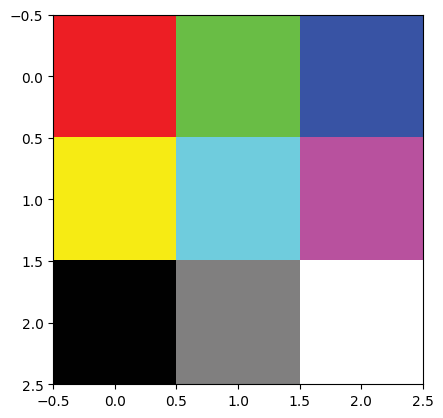

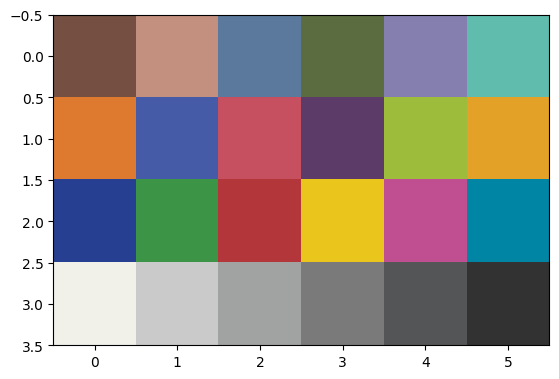

In [5]:
# 推論データold
X =  np.array([[0.63, 0.12, 0.07],
               [0.24, 0.88, 0.22],
               [0.07, 0.28, 0.40],
               [0.88, 0.99, 0.28],
               [0.40, 0.98, 0.91],
               [0.56, 0.20, 0.27],
               [0.00, 0.00, 0.00],
               [0.28, 0.53, 0.36], 
               [0.97, 1.00, 0.99],
               
               [0.22, 0.13, 0.06],
               [0.65, 0.64, 0.36],
               [0.15, 0.43, 0.42],
               [0.15, 0.37, 0.10],
               [0.34, 0.55, 0.55],
               [0.28, 0.96, 0.68],

               [0.68, 0.38, 0.08],
               [0.02, 0.25, 0.37],
               [0.60, 0.14, 0.11],
               [0.11, 0.05, 0.10],
               [0.49, 0.97, 0.22],
               [0.76, 0.74, 0.16],
               
               [0.01, 0.08, 0.18],
               [0.08, 0.59, 0.16],
               [0.49, 0.09, 0.03],
               [0.83, 0.97, 0.23],
               [0.59, 0.16, 0.19],
               [0.09, 0.57, 0.57],
               
               [1.00, 1.00, 1.00],
               [0.68, 0.97, 0.74],
               [0.44, 0.71, 0.49],
               [0.25, 0.45, 0.30],
               [0.11, 0.17, 0.13],
               [0.00, 0.03, 0.01],], dtype=np.float32)

img1 = cv2.resize(cv2.imread("img/reference_image1_cmyk_large.png", cv2.IMREAD_COLOR_RGB), (3,3), interpolation=cv2.INTER_NEAREST)
img2 = cv2.resize(cv2.imread("img/reference_image2_cmyk_large.png", cv2.IMREAD_COLOR_RGB), (6,4), interpolation=cv2.INTER_NEAREST)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

# 正解データ
Y = np.concatenate([img1.reshape([-1, 3])/255, img2.reshape([-1, 3])/255], axis=0).astype(np.float32)

In [6]:
# このセルは削除されました。Cell 4（推論データold）を使用してください。

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# ========== モデル設定（次元を変更する場合はここを編集） ==========
HIDDEN_DIM = 40  # 隠れ層の次元（40, 100, 200などに変更可能）
# ================================================================

# モデル定義
class ColorNet(nn.Module):
    def __init__(self, hidden_dim=40):
        super(ColorNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.model = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3),
        )

    def predict(self, x):
        return self.model(x)

model = ColorNet(hidden_dim=HIDDEN_DIM)
print(f"モデル定義完了: 隠れ層次元 = {HIDDEN_DIM}")

# 損失関数（MSE）
criterion = nn.MSELoss()

# 最適化手法
optimizer = optim.Adam(model.parameters(), lr=0.01)

# L1正則化の係数
lambda_l1 = 1e-6

# 学習ループ
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_tensor)
    mse = criterion(outputs, Y_tensor)

    # --- L1 正則化-----------------------------
    l1 = torch.tensor(0.0, requires_grad=False)
    for name, p in model.named_parameters():
        if 'weight' in name:
            l1 = l1 + p.abs().sum()
    loss = mse + lambda_l1 * l1
    # -----------------------------------------

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}]  MSE: {mse.item():.6f}  L1: {l1.item():.2f}  Loss: {loss.item():.6f}')

with torch.no_grad():
    predictions = model(X_tensor)
    print("\n予測結果：")
    print(predictions.numpy())

def convert_to_cpp_array(tensor: torch.Tensor, name: str, dtype: str = "float"):
    flat = tensor.detach().numpy().flatten()
    array_str = f"{dtype} {name}[] = {{"
    array_str += ", ".join(map(str, flat))
    array_str += "};"
    return array_str

cpp_code = f"// モデルパラメータ (隠れ層次元: {HIDDEN_DIM})\n"

layer_idx = 1
for layer in model.model:
    if isinstance(layer, torch.nn.Linear):
        cpp_code += convert_to_cpp_array(layer.weight, f"weight_{layer_idx}") + "\n"
        cpp_code += convert_to_cpp_array(layer.bias,   f"bias_{layer_idx}") + "\n"
        layer_idx += 1

with open("model_parameters.h", "w") as f:
    f.write(cpp_code)

print(f"\nC++ 用のパラメータファイル (model_parameters.h) を作成しました。")
print(f"隠れ層次元: {HIDDEN_DIM}")


モデル定義完了: 隠れ層次元 = 40
Epoch [0/50000]  MSE: 0.458537  L1: 166.16  Loss: 0.458703
Epoch [500/50000]  MSE: 0.001930  L1: 126.19  Loss: 0.002056
Epoch [1000/50000]  MSE: 0.001137  L1: 133.98  Loss: 0.001271
Epoch [1500/50000]  MSE: 0.000707  L1: 134.93  Loss: 0.000841
Epoch [2000/50000]  MSE: 0.000579  L1: 134.43  Loss: 0.000714
Epoch [2500/50000]  MSE: 0.000438  L1: 133.75  Loss: 0.000572
Epoch [3000/50000]  MSE: 0.000367  L1: 130.27  Loss: 0.000497
Epoch [3500/50000]  MSE: 0.000277  L1: 128.11  Loss: 0.000405
Epoch [4000/50000]  MSE: 0.000211  L1: 128.06  Loss: 0.000339
Epoch [4500/50000]  MSE: 0.000209  L1: 127.95  Loss: 0.000337
Epoch [5000/50000]  MSE: 0.000163  L1: 126.26  Loss: 0.000290
Epoch [5500/50000]  MSE: 0.000146  L1: 124.93  Loss: 0.000271
Epoch [6000/50000]  MSE: 0.000141  L1: 124.36  Loss: 0.000265
Epoch [6500/50000]  MSE: 0.000212  L1: 124.38  Loss: 0.000336
Epoch [7000/50000]  MSE: 0.000094  L1: 123.84  Loss: 0.000218
Epoch [7500/50000]  MSE: 0.000078  L1: 123.33  Loss: 0

In [8]:
import numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix
from pathlib import Path

# ========== CSR圧縮設定 ==========
PRUNING_THRESHOLD = 0.01  # プルーニングのしきい値（調整可能）
# ================================

# 重要: Cell 6で学習したモデルを再利用します
# Cell 6を先に実行して、model変数が定義されていることを確認してください
if 'model' not in globals():
    raise ValueError("エラー: Cell 6を先に実行して、モデルを学習してください。")

print(f"Cell 6で学習したモデルを再利用します（隠れ層次元: {HIDDEN_DIM}）")

# 1層目と2層目を取得
first_linear = None
second_linear = None
for layer in model.model:
    if isinstance(layer, torch.nn.Linear):
        if layer.in_features == 3 and layer.out_features == HIDDEN_DIM:
            first_linear = layer
        elif layer.in_features == HIDDEN_DIM and layer.out_features == HIDDEN_DIM:
            second_linear = layer

if first_linear is None:
    raise ValueError(f"1層目（3->{HIDDEN_DIM}）が見つかりません")
if second_linear is None:
    raise ValueError(f"2層目（{HIDDEN_DIM}->{HIDDEN_DIM}）が見つかりません")

# ========== 1層目のCSR圧縮 ==========
W1 = first_linear.weight.detach().cpu().numpy().copy()  # (HIDDEN_DIM, 3)
b1 = first_linear.bias.detach().cpu().numpy().copy()    # (HIDDEN_DIM,)

print(f"\n【1層目】元の重み行列サイズ: {W1.shape} ({W1.size} 要素)")

# 1) プルーニング（固定しきい値）
non_zero_before_1 = np.count_nonzero(W1)
W1[np.abs(W1) < PRUNING_THRESHOLD] = 0.0
non_zero_after_1 = np.count_nonzero(W1)
sparsity_1 = (1 - non_zero_after_1 / W1.size) * 100

print(f"プルーニング前の非ゼロ要素: {non_zero_before_1}")
print(f"プルーニング後の非ゼロ要素: {non_zero_after_1}")
print(f"スパース性: {sparsity_1:.2f}%")

# 2) CSR化
csr1 = csr_matrix(W1)  # 行=出力(HIDDEN_DIM), 列=入力(3)
data_1 = csr1.data.astype(np.float32)
indices_1 = csr1.indices.astype(np.uint16)
indptr_1 = csr1.indptr.astype(np.uint16)  # 長さ HIDDEN_DIM+1

print(f"  data_1: {data_1.size} 要素")
print(f"  indices_1: {indices_1.size} 要素")
print(f"  indptr_1: {indptr_1.size} 要素")
print(f"  圧縮率: {W1.size / (data_1.size + indices_1.size + indptr_1.size):.2f}x")

# ========== 2層目のCSR圧縮 ==========
W2 = second_linear.weight.detach().cpu().numpy().copy()  # (HIDDEN_DIM, HIDDEN_DIM)
b2 = second_linear.bias.detach().cpu().numpy().copy()    # (HIDDEN_DIM,)

print(f"\n【2層目】元の重み行列サイズ: {W2.shape} ({W2.size} 要素)")

# 1) プルーニング（固定しきい値）
non_zero_before_2 = np.count_nonzero(W2)
W2[np.abs(W2) < PRUNING_THRESHOLD] = 0.0
non_zero_after_2 = np.count_nonzero(W2)
sparsity_2 = (1 - non_zero_after_2 / W2.size) * 100

print(f"プルーニング前の非ゼロ要素: {non_zero_before_2}")
print(f"プルーニング後の非ゼロ要素: {non_zero_after_2}")
print(f"スパース性: {sparsity_2:.2f}%")

# 2) CSR化
csr2 = csr_matrix(W2)  # 行=出力(HIDDEN_DIM), 列=入力(HIDDEN_DIM)
data_2 = csr2.data.astype(np.float32)
indices_2 = csr2.indices.astype(np.uint16)
indptr_2 = csr2.indptr.astype(np.uint16)  # 長さ HIDDEN_DIM+1

print(f"  data_2: {data_2.size} 要素")
print(f"  indices_2: {indices_2.size} 要素")
print(f"  indptr_2: {indptr_2.size} 要素")
print(f"  圧縮率: {W2.size / (data_2.size + indices_2.size + indptr_2.size):.2f}x")

# 3) C配列としてヘッダ出力（1層目と2層目をCSRに）
def to_c_array(name, arr, ctype):
    elems = ", ".join(map(str, arr.tolist()))
    return f"{ctype} {name}[] = {{{elems}}};\n"

out = []
out.append(f"// CSR形式パラメータ (隠れ層次元: {HIDDEN_DIM}, プルーニングしきい値: {PRUNING_THRESHOLD})\n")
out.append("// 1層目 (3 -> HIDDEN_DIM)\n")
out.append(to_c_array("data_1", data_1, "float"))
out.append(to_c_array("indices_1", indices_1, "uint16_t"))
out.append(to_c_array("indptr_1", indptr_1, "uint16_t"))
out.append("// 2層目 (HIDDEN_DIM -> HIDDEN_DIM)\n")
out.append(to_c_array("data_2", data_2, "float"))
out.append(to_c_array("indices_2", indices_2, "uint16_t"))
out.append(to_c_array("indptr_2", indptr_2, "uint16_t"))

filename = f"model_parameters_csr{HIDDEN_DIM}.h"
Path(filename).write_text("".join(out), encoding="utf-8")

print(f"\nCSR形式パラメータを出力しました: {filename}")

Cell 6で学習したモデルを再利用します（隠れ層次元: 40）

【1層目】元の重み行列サイズ: (40, 3) (120 要素)
プルーニング前の非ゼロ要素: 120
プルーニング後の非ゼロ要素: 37
スパース性: 69.17%
  data_1: 37 要素
  indices_1: 37 要素
  indptr_1: 41 要素
  圧縮率: 1.04x

【2層目】元の重み行列サイズ: (40, 40) (1600 要素)
プルーニング前の非ゼロ要素: 1600
プルーニング後の非ゼロ要素: 94
スパース性: 94.12%
  data_2: 94 要素
  indices_2: 94 要素
  indptr_2: 41 要素
  圧縮率: 6.99x

CSR形式パラメータを出力しました: model_parameters_csr40.h


In [9]:
# ========== 量子化（CSR完了後、オプション） ==========
# 注意: 量子化はCSR形式のパラメータに対して適用します
# 8-bit量子化を想定（必要に応じて調整）

import numpy as np
from pathlib import Path

# CSRデータを量子化
def quantize_to_int8(data, scale_factor=None):
    """
    float32のデータをint8に量子化
    scale_factorがNoneの場合は自動計算
    """
    if scale_factor is None:
        # データの最大絶対値からスケールを決定
        max_val = np.max(np.abs(data))
        scale_factor = 127.0 / max_val if max_val > 0 else 1.0
    
    quantized = np.clip(np.round(data * scale_factor), -128, 127).astype(np.int8)
    return quantized, scale_factor

def dequantize_from_int8(quantized, scale_factor):
    """int8からfloat32に逆量子化"""
    return quantized.astype(np.float32) / scale_factor

# CSRデータの量子化（オプション: 実行する場合はコメントアウトを外す）
USE_QUANTIZATION = True  # Trueにすると量子化を適用

if USE_QUANTIZATION:
    # 前のセルで生成されたCSRデータを使用
    # 注意: このセルは前のセルの後に実行してください
    try:
        # 1層目の量子化
        data_1_quantized, scale_factor_1 = quantize_to_int8(data_1)
        data_1_dequantized = dequantize_from_int8(data_1_quantized, scale_factor_1)
        quantization_error_1 = np.mean(np.abs(data_1 - data_1_dequantized))
        
        print(f"\n【1層目】量子化結果:")
        print(f"  元のデータ範囲: [{np.min(data_1):.6f}, {np.max(data_1):.6f}]")
        print(f"  スケールファクタ: {scale_factor_1:.6f}")
        print(f"  平均量子化誤差: {quantization_error_1:.6f}")
        
        # 2層目の量子化
        data_2_quantized, scale_factor_2 = quantize_to_int8(data_2)
        data_2_dequantized = dequantize_from_int8(data_2_quantized, scale_factor_2)
        quantization_error_2 = np.mean(np.abs(data_2 - data_2_dequantized))
        
        print(f"\n【2層目】量子化結果:")
        print(f"  元のデータ範囲: [{np.min(data_2):.6f}, {np.max(data_2):.6f}]")
        print(f"  スケールファクタ: {scale_factor_2:.6f}")
        print(f"  平均量子化誤差: {quantization_error_2:.6f}")
        
        # 量子化されたCSRパラメータを出力
        def to_c_array(name, arr, ctype):
            elems = ", ".join(map(str, arr.tolist()))
            return f"{ctype} {name}[] = {{{elems}}};\n"
        
        out_quantized = []
        out_quantized.append(f"// 量子化CSR形式パラメータ (隠れ層次元: {HIDDEN_DIM})\n")
        out_quantized.append("// 1層目 (3 -> HIDDEN_DIM)\n")
        out_quantized.append(to_c_array("data_1_quantized", data_1_quantized, "int8_t"))
        out_quantized.append(f"float scale_factor_1 = {scale_factor_1};\n")
        out_quantized.append(to_c_array("indices_1", indices_1, "uint16_t"))
        out_quantized.append(to_c_array("indptr_1", indptr_1, "uint16_t"))
        out_quantized.append("// 2層目 (HIDDEN_DIM -> HIDDEN_DIM)\n")
        out_quantized.append(to_c_array("data_2_quantized", data_2_quantized, "int8_t"))
        out_quantized.append(f"float scale_factor_2 = {scale_factor_2};\n")
        out_quantized.append(to_c_array("indices_2", indices_2, "uint16_t"))
        out_quantized.append(to_c_array("indptr_2", indptr_2, "uint16_t"))
        
        filename = f"model_parameters_csr_quantized{HIDDEN_DIM}.h"
        Path(filename).write_text("".join(out_quantized), encoding="utf-8")
        print(f"\n量子化CSR形式パラメータを出力しました: {filename}")
    except NameError:
        print("エラー: 前のセルでCSRパラメータを生成してください")
else:
    print("量子化はスキップされました（USE_QUANTIZATION = False）")



【1層目】量子化結果:
  元のデータ範囲: [-1.711221, 1.901482]
  スケールファクタ: 66.790009
  平均量子化誤差: 0.003247

【2層目】量子化結果:
  元のデータ範囲: [-3.596975, 1.571822]
  スケールファクタ: 35.307442
  平均量子化誤差: 0.007145

量子化CSR形式パラメータを出力しました: model_parameters_csr_quantized40.h
